Mental Health Classification Project

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

label_map = {
    "Normal": 0,
    "Depression": 1,
    "Suicidal": 2,
    "Anxiety": 3,
    "Stress": 4,
    "Bipolar": 5,
    "Personality Disorder": 6
}


db = pd.read_csv('Sentiment_analysis_dataset(in).csv')


c:\Users\Laure\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Unique labels in dataset:", db['Status'].unique())


Unique labels in dataset: ['Depression' 'Stress' 'Normal' 'Suicidal' 'Anxiety'
 'Personality disorder' 'Bipolar' nan]


In [47]:
db = db.dropna(subset=['Statement', 'Status'])
db['Status'] = db['Status'].str.strip().str.title()
db['Statement'] = db['Statement'].apply(lambda x: x.lower())
unmapped = set(db['Status'].unique()) - set(label_map.keys())
if unmapped:
    print("Warning: These labels aren't in your map:", unmapped)
    db = db[db['Status'].isin(label_map.keys())]

statement = db['Statement'].tolist()
status = db['Status'].tolist()

print(db.head(20))

                                            Statement      Status
0   life doesn’t feel worth it that’s kind of it? ...  Depression
1   this life sucks and if it were for my religiou...  Depression
2   its been 9 months now for our marriage and she...      Stress
3   i do not feel particularly sad or anxious or a...  Depression
4   i am taking venlafaxine. it is an ssri. does n...  Depression
5   i (17m) have come to the realisation that my d...  Depression
6   been on fluoxetine for year but anyway there s...  Depression
7   even a four day week seems too long i want to ...      Normal
8   i often had suicidal thoughts, recently, with ...    Suicidal
9   this is the first time facing pisces. extro pa...      Normal
10  being an orphan at your early stages of life b...  Depression
11  the dread of thinking you have cancer... again...     Anxiety
12  i (30f) married my husband (31m) about 6 month...      Stress
13           what day is eid al-fitr if you may know?      Normal
14  free c

In [4]:
train_texts, val_texts, train_labels, val_labels = train_test_split(db['Statement'], db['Status'], test_size=0.2, random_state=42)

train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

print(f"training data size: {len(train_texts)}")
print(f"Testing data size: {len(val_texts)}")

training data size: 29500
Testing data size: 7375


In [5]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True,padding=True)

print(type(train_texts))
print(type(train_texts[0]))


<class 'pandas.core.series.Series'>
<class 'str'>


In [6]:
print(train_texts.head())



36248    i want everyone to feel my pain i am sick of e...
26254    home. had uni today, got results back :hd, yeh...
8331                                          really? why?
26739    i am not sure how much longer i can last. i al...
18584    i feel so trapped in my mind, the feeling that...
Name: Statement, dtype: object


In [7]:
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, label_map):
        self.encodings = encodings
        self.labels = labels
        self.label_map = label_map

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label = self.labels.iloc[idx]
        #item["labels"] = torch.tensor(self.label_map[idx])
        item["labels"] = torch.tensor(self.label_map[label])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MentalHealthDataset(train_encodings, train_labels, label_map)
val_dataset = MentalHealthDataset(val_encodings, val_labels, label_map)

In [8]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 7)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.500100,0.499798
2,0.365400,0.494076
3,0.261800,0.612386


TrainOutput(global_step=11064, training_loss=0.4172975892013859, metrics={'train_runtime': 38499.343, 'train_samples_per_second': 2.299, 'train_steps_per_second': 0.287, 'total_flos': 1.1724410128896e+16, 'train_loss': 0.4172975892013859, 'epoch': 3.0})

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [12]:
model_path = "./model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
trainer.save_state()


In [14]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [21]:
import torch

def predict_label(text, model, tokenizer, label_map):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    
    predicted_label_id = torch.argmax(probs, dim=1).item()
    label_name = list(label_map.keys())[list(label_map.values()).index(predicted_label_id)]
    
    return label_name, probs.detach().numpy()

In [34]:
test_statements = [
    "I am so stressed out and tired. I'm so done",
    "Life is so empty and hopeless",
    "I'm fine. Nice weather today!",
    "I have so much homework I'm gonna fail my class.",
    "My dog died. Life has become dull and I'm really sad.",
    "I'm always mad or sad what the hell.",
    "sometimes i hear voices and they confuse me",
    "I'm depressed",
    "I'm anxious"
]

for text in test_statements:
    label, _ = predict_label(text, model, tokenizer, label_map)
    print(f"Input: {text}")
    print(f"Predicted Label: {label}")
    print("---")

Input: I am so stressed out and tired. I'm so done
Predicted Label: Normal
---
Input: Life is so empty and hopeless
Predicted Label: Suicidal
---
Input: I'm fine. Nice weather today!
Predicted Label: Suicidal
---
Input: I have so much homework I'm gonna fail my class.
Predicted Label: Normal
---
Input: My dog died. Life has become dull and I'm really sad.
Predicted Label: Normal
---
Input: I'm always mad or sad what the hell.
Predicted Label: Normal
---
Input: sometimes i hear voices and they confuse me
Predicted Label: Normal
---
Input: I'm depressed
Predicted Label: Suicidal
---
Input: I'm anxious
Predicted Label: Suicidal
---


In [31]:
trainer.evaluate()

{'eval_loss': 1.947523832321167,
 'eval_model_preparation_time': 0.0038,
 'eval_accuracy': 0.09084745762711864,
 'eval_f1': 0.05975041524765646,
 'eval_runtime': 1435.9369,
 'eval_samples_per_second': 5.136,
 'eval_steps_per_second': 0.642}

In [44]:
from sklearn.utils.class_weight import compute_class_weight
train_labels_int = train_labels.map(label_map)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(list(label_map.values())),
    y=train_labels_int
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

from transformers import DistilBertConfig
import torch.nn as nn
from transformers import DistilBertForSequenceClassification

class WeightedDistilBERT(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        kwargs.pop("num_items_in_batch", None)

        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=None, **kwargs)
        logits = outputs.logits

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels)

        return {
            "loss": loss,
            "logits": logits,
            "hidden_states": outputs.hidden_states,
            "attentions": outputs.attentions,
        }

config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=7)
model = WeightedDistilBERT.from_pretrained(
    "distilbert-base-uncased",
    config=config,
    local_files_only=False,
    class_weights = class_weights
)

Class Weights: tensor([0.4618, 0.4876, 0.6994, 1.9638, 2.8944, 2.7726, 7.2162])


Some weights of WeightedDistilBERT were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
model2_path = "./model2"
trainer.save_model(model2_path)
tokenizer.save_pretrained(model2_path)
trainer.save_state()

In [42]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    eval_strategy="epoch",
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.571400,0.596059
2,0.400700,0.617954
3,0.343000,0.662998


TrainOutput(global_step=11064, training_loss=0.49908538426684024, metrics={'train_runtime': 55072.2081, 'train_samples_per_second': 1.607, 'train_steps_per_second': 0.201, 'total_flos': 1.1724410128896e+16, 'train_loss': 0.49908538426684024, 'epoch': 3.0})

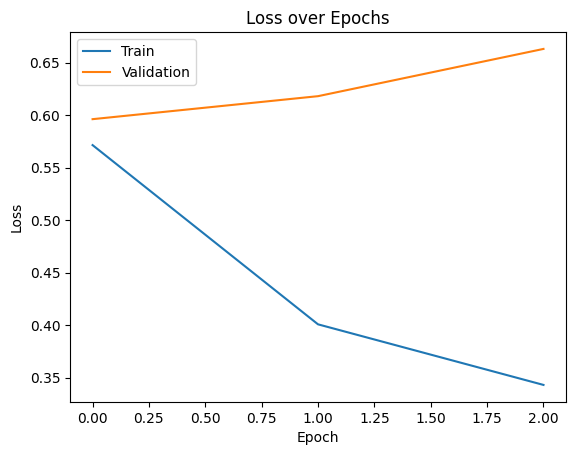

In [43]:
import matplotlib.pyplot as plt #running to visualizing the thing:


train_loss = [0.5714, 0.4007, 0.3430]
val_loss = [0.5961, 0.6180, 0.6630]

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

In [46]:
from transformers import DistilBertConfig
from transformers import EarlyStoppingCallback

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=7,
    dropout=0.3,
    attention_dropout=0.3
)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=3e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    eval_strategy="epoch",
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    tokenizer = tokenizer
)

trainer.train()

C:\Users\Laure\AppData\Local\Temp\ipykernel_5160\1599573546.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.616300,0.597225
2,0.439600,0.596044
3,0.318000,0.714337


TrainOutput(global_step=11064, training_loss=0.5057889125697094, metrics={'train_runtime': 56554.8254, 'train_samples_per_second': 2.608, 'train_steps_per_second': 0.326, 'total_flos': 1.1724410128896e+16, 'train_loss': 0.5057889125697094, 'epoch': 3.0})